# Receiver Operating Characteristics (ROC)

In [1]:
%matplotlib inline

In [85]:
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

# some classification metrics
# more here: 
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import (auc, roc_curve, roc_auc_score,
                             accuracy_score, precision_score,
                             recall_score, f1_score, )

from sklearn.cross_validation import train_test_split



# a few classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 1. Binary classification

In [25]:
# breast cancer dataset, a binary classification task
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

x_train, x_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target,
                                                    test_size=0.4,
                                                    random_state=0)

In [43]:
x_train.shape

(341, 30)

In [26]:
# only two class, 0 and 1
set(y_train)

{0, 1}

In [30]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Accuracy, precision, recall

In [46]:
# score by default calculate the accuracy for a classifier
print '%30s: %s' % ('Default score (accuracy)', clf.score(x_train, y_train))

      Default score (accuracy): 0.958944281525


In [34]:
# predict outputs the predicted class label given the dataset features
# this might seem odd given that the model has already seen all of x_train
# however most of the time models do not fit the training data perfectly
# therefore you didn't see 100% accuracy above
# as you increase the model complexity (e.g. random forest, neural network, etc.)
# there's a higher likelihood that your model will fit the training data perfectly
# but as you'll learn this is most likely not a good thing (i.e. overfit)

predicted_labels = clf.predict(x_train)
predicted_labels[:5]

array([1, 0, 1, 1, 1])

In [48]:
# notice that this is the same as what we computed earlier
print '%30s: %s' % ('Accuracy', accuracy_score(y_train, predicted_labels))

                      Accuracy: 0.958944281525


In [49]:
# precision is calculated as the ratio of true positives
# over the sum of true positives and false positives
# we'll come back to this later

print '%30s: %s' % ('Precision', precision_score(y_train, predicted_labels))

                     Precision: 0.958333333333


In [50]:
# recall or sensitivity is the ratio of true positives
# over the sum of true positives and false negatives
# we'll come back to this later

print '%30s: %s' % ('Recall', recall_score(y_train, predicted_labels))

                        Recall: 0.97641509434


**Note: ** These are considered VERY good quality metrics in most cases which should raise suspicision. In this case the problem is that we're training and calculating scores on the same dataset.

**Quiz:** Why is training and testing on the same dataset a bad idea?

### AUC score

Looking at the **roc_auc_score** signature from the sklearn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html">documentation</a>:

```roc_auc_score(y_true, y_score, average='macro')```


One might be tempted to try the following:

In [54]:
print '%30s: %s' % ('AUC (not correct)', roc_auc_score(y_train, predicted_labels))

             AUC (not correct): 0.95332382624


The problem here is that we're not passing the correct second argument.

**y_score** has to be:
> Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).

Let's calculate the probability estimates. With most classifiers you can get this using **predict_proba**.

In [55]:
predicted_probabilities = clf.predict_proba(x_train)

In [56]:
predicted_probabilities[:5]

array([[  4.34552482e-03,   9.95654475e-01],
       [  1.00000000e+00,   7.11019374e-16],
       [  1.21951155e-02,   9.87804885e-01],
       [  1.08264238e-02,   9.89173576e-01],
       [  8.19547425e-03,   9.91804526e-01]])

For each record in the training dataset **predict_proba** outputs a probabilty per class. In our example this takes the form of:

```[probability of class 1, probability of class 2]```

These two probabilities sum to one. For example the first row (4.34552482e-03 + 9.95654475e-01 ~=1).

In [57]:
predicted_probabilities.shape

(341, 2)

Make sure that all rows sum to 1.

In [76]:
assert all(predicted_probabilities.sum(axis=1) == 1), "At least one row is not summing to one"

**Quiz:** what is `assert`? what is `all`? what is `axis=1` doing? why is there no output?

Let's calculate the the AUC score by passing the correct metric. We have to pass the probability for the positive class which corresponds to the 2nd column.

In [72]:
print '%30s: %s' % ('AUC', roc_auc_score(y_train, predicted_probabilities[:, 1]))

                           AUC: 0.991955536054


Passing the wrong column (negative class) result in 1-AUC.

In [74]:
print '%30s: %s' % ('1 - AUC', roc_auc_score(y_train, predicted_probabilities[:, 0]))

                       1 - AUC: 0.00804446394618


#### Does this work with decision trees?

In [77]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [80]:
predicted_labels = clf.predict(x_train)
print '%30s: %s' % ('Accuracy', accuracy_score(y_train, predicted_labels))

                      Accuracy: 1.0


In [78]:
predicted_probabilities = clf.predict_proba(x_train)
print '%30s: %s' % ('AUC', roc_auc_score(y_train, predicted_probabilities[:, 1]))

                           AUC: 1.0


#### Accuracy and AUC score of 1???
**Quiz:** why are we getting perfect accuracy and AUC?

In fact we can calcualte all these metrics for any classifer (except for ROC/AUC). So let's refactor the code and make it more generic.

In [81]:
def classifier_metrics(model):
    clf = model()
    clf.fit(x_train, y_train)
    print '%30s: %s' % ('Default score (accuracy)', clf.score(x_train, y_train))
    predicted_labels = clf.predict(x_train)
    print '%30s: %s' % ('Accuracy', accuracy_score(y_train, predicted_labels))
    print '%30s: %s' % ('Precision', accuracy_score(y_train, predicted_labels))
    print '%30s: %s' % ('Recall', accuracy_score(y_train, predicted_labels))
    print '%30s: %s' % ('F1', f1_score(y_train, predicted_labels))
    
    try:
        predicted_probabilities = clf.predict_proba(x_train)
        print '%30s: %s' % ('AUC', roc_auc_score(y_train, predicted_probabilities[:, 1]))
    except:
        print '*** predict_proba failed for %s' % model.__name__

#### Let's try the following models:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- SVC (Support Vector Classification)

In [88]:
for model in [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SVC]:
    print 'Metrics for %s' % model.__name__
    print '=' * 50
    classifier_metrics(model)
    print '\n'

Metrics for LogisticRegression
      Default score (accuracy): 0.958944281525
                      Accuracy: 0.958944281525
                     Precision: 0.958944281525
                        Recall: 0.958944281525
                            F1: 0.967289719626
                           AUC: 0.991955536054


Metrics for DecisionTreeClassifier
      Default score (accuracy): 1.0
                      Accuracy: 1.0
                     Precision: 1.0
                        Recall: 1.0
                            F1: 1.0
                           AUC: 1.0


Metrics for RandomForestClassifier
      Default score (accuracy): 1.0
                      Accuracy: 1.0
                     Precision: 1.0
                        Recall: 1.0
                            F1: 1.0
                           AUC: 1.0


Metrics for SVC
      Default score (accuracy): 1.0
                      Accuracy: 1.0
                     Precision: 1.0
                        Recall: 1.0
                   

#### No AUC for SVC?
Suffice it to say right now that SVC by default does not generate probabilities. We'll come back to this later. The point is that **not all classifiers output probabilities** and therefore we can't always calculate AUC.

### ROC curve

Let's say that our "cancer" classifier is predicting the following probabilities for patients A, B, C, D, and E:
- A, 50% chance of having cancer
- B, 99% chance of having cancer
- C, 80% chance of having cancer
- D, 40% chance of having cancer
- E, 2% chance of having cancer

Which patients should we call in for further screening?

Before we proceed here's some terminology:
- The **positive class** (since we want to predict it) is "having cancer".
- The **negative class** is not having cancer.
- A **false positive** means predicting someone has cancer who does not.
- A **false negative** means predicting someone doesn't have cancer when they actually do.

Here are a few different ways to go about it:
- Let's call in everyone, even 2% means there's a chance and we don't want to risk missing someone. If we decide to proceed this way we're going to have zero false negatives, but probably a lot of false positives. Do we really want to put everyone through all the screening and incur the cost?
- Let's call in patients with probability > 95%. This way we're going to have very little false positives, assuming the model probabilities map to reality (they're calibrated). But we're going to miss many actual patients. So low false positives at the expense of high false negatives.
- Let's call people with probability > 50%. Since this is really a trade-off a simple answer is to pick the most intuitive probability (50%). 

This is the essence of the ROC curve. The number you pick as the threshold gives you one point on the ROC curve. Plotting the ROC curve involves changing the threshold from 1 to 0 in small increments and plotting the corresponding points (more details to follow).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/ROC_space-2.png/640px-ROC_space-2.png">

### Plotting the ROC curve

In [115]:
# same as before
clf = LogisticRegression()
clf.fit(x_train, y_train)
predicted_probabilities = clf.predict_proba(x_train)
roc_auc = roc_auc_score(y_train, predicted_probabilities[:, 1])

`roc_curve` generates the coordinates of the ROC curve (fpr and tpr) that are needed for plotting it. It also generates the 

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train,
                                 predicted_probabilities[:, 1])

Note that the thresholds are not equi-distance. This has to do with removing redundant coordinates.

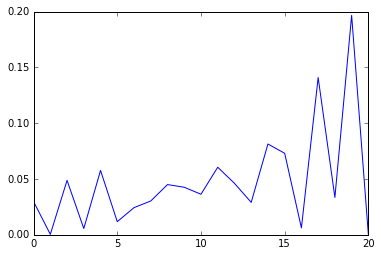

In [129]:
# distance between consequtive thresholds
# x-axis is diff index, y axis is difference
plt.plot(np.abs(np.diff(thresholds)));

### The actual plot
Now we have everything we need.

**Quiz:** why is thresholds not used for plotting?

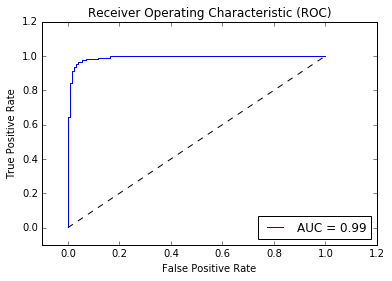

In [108]:
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b',
        label='AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 2. Multi-class classification

Coming soon

Page 197-

# 3. Confusion matrix

Coming soon

- http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
- https://www.wikiwand.com/en/Confusion_matrix

# Other stuff

### Missing values

https://github.com/Quartz/bad-data-guide/blob/master/README.md

https://www.quora.com/What-are-the-best-ways-to-account-for-missing-data-in-machine-learning

http://diggdata.in/post/90435663721/dealing-with-missing-values-introduction

http://scikit-learn.org/stable/auto_examples/missing_values.html#sphx-glr-auto-examples-missing-values-py

http://nerds.airbnb.com/overcoming-missing-values-in-a-rfc/ (fill using KNN)

https://www.wikiwand.com/en/Imputation_(statistics)

How does CART deal with missing values?

https://www.quora.com/How-does-XGBoost-treat-missing-values-during-training-and-prediction

https://github.com/dmlc/xgboost/issues/21

http://stats.stackexchange.com/questions/96025/how-do-decision-tree-learning-algorithms-deal-with-missing-values-under-the-hoo

1. Missing Completely At Random (MCAR)
There may be no particular reason why some respondents told you their weights and others didn’t. That is, the probability that Y is missing may has no relationship to X or Y. In this case our data is missing completely at random (MCAR).
2. Missing At Random (MAR)
One gender may be less likely to disclose its weight. That is, the probability that Y is missing depends only on the value of X. Such data are missing at random (MAR)
3. Missing Not At Random (MNAR)
Heavy (or light) people or rich females may be less likely to disclose their weight. That is, the probability that Y is missing depends on the unobserved value of Y itself. Such data are not missing at random or missing not at random (MNAR)


### Imbalanced datasets

https://github.com/scikit-learn-contrib/imbalanced-learn

http://www.fundraisingwithr.com/solutions-for-modeling-imbalanced-data/

### Grid search pipeline

http://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html
    
https://github.com/rasbt/python-machine-learning-book